In [1]:
import json
import os
from collections import OrderedDict
import json
import networkx as nx
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [2]:
# Define relation mapping
REL_LABELS = [
    "USED-FOR",
    "PART-OF",
    "FEATURE-OF",
    "COMPARE",
    "CONJUNCTION",
    "EVALUATE-FOR",
    "HYPONYM-OF",
]
REL2ID = {label: i for i, label in enumerate(REL_LABELS)}

In [3]:
def flatten_sentences(sentences):
    """
    Flatten a list of tokenized sentences into a single list of tokens.
    """
    flat = []
    for sent in sentences:
        flat.extend(sent)
    return flat

def load_scierc_file(path):
    """
    Load a SciERC annotation file, supporting both JSON arrays and JSONL formats.
    """
    with open(path, 'r') as f:
        # Peek first non-whitespace character
        first_char = None
        while True:
            ch = f.read(1)
            if not ch:
                break
            if not ch.isspace():
                first_char = ch
                break
        f.seek(0)
        if first_char == '[':
            # Standard JSON array
            return json.load(f)
        else:
            # JSONL: one JSON object per line
            docs = []
            for line in f:
                line = line.strip()
                if not line:
                    continue
                docs.append(json.loads(line))
            return docs


def preprocess_scierc(input_paths):
    # Initialize accumulators
    entities = {}
    triples = []
    entity_counter = 0

    for input_path in input_paths:
        data = load_scierc_file(input_path)

        for doc in data:
            doc_id = doc.get('doc_key', f"DOC{entity_counter}")
            flat_tokens = flatten_sentences(doc['sentences'])

            # Map mention spans to entity IDs
            span2ent = {}
            # Coreference clusters
            for cluster in doc.get('clusters', []):
                first_span = cluster[0]
                text = ' '.join(flat_tokens[first_span[0]: first_span[1] + 1])
                ent_id = f"{doc_id}_E{entity_counter}"
                entity_counter += 1
                entities[ent_id] = {
                    'canonical': text,
                    'mentions': [tuple(span) for span in cluster]
                }
                for span in cluster:
                    span2ent[tuple(span)] = ent_id

            # Singleton mentions
            for ner_list in doc.get('ner', []):
                for start, end, _ in ner_list:
                    if (start, end) not in span2ent:
                        text = ' '.join(flat_tokens[start:end + 1])
                        ent_id = f"{doc_id}_E{entity_counter}"
                        entity_counter += 1
                        entities[ent_id] = {
                            'canonical': text,
                            'mentions': [(start, end)]
                        }
                        span2ent[(start, end)] = ent_id

            # Relations
            for rel_list in doc.get('relations', []):
                for head_s, head_e, tail_s, tail_e, rel_label in rel_list:
                    head_ent = span2ent.get((head_s, head_e))
                    tail_ent = span2ent.get((tail_s, tail_e))
                    if head_ent and tail_ent and rel_label in REL2ID:
                        rel_id = REL2ID[rel_label]
                        triples.append((head_ent, rel_id, tail_ent))

    return entities, triples


In [4]:
def preprocess_scierc_datasplit(train_files, dev_files, test_files, output_dir):
    entities = {}
    span2ent = {}    # maps (doc_id, span) -> entity_id
    entity_counter = 0
    # prepare triple collectors
    triples = {'train': [], 'dev': [], 'test': []}

    def process_doc(doc, split):
        nonlocal entity_counter
        doc_key = doc.get('doc_key', f"DOC{entity_counter}")
        flat_tokens = flatten_sentences(doc['sentences'])
        # clusters
        for cluster in doc.get('clusters', []):
            first = cluster[0]
            text = ' '.join(flat_tokens[first[0]: first[1]+1])
            ent_id = f"{doc_key}_E{entity_counter}"
            entity_counter += 1
            entities[ent_id] = {'canonical': text, 'mentions': [tuple(span) for span in cluster]}
            for span in cluster:
                span2ent[(doc_key, span[0], span[1])] = ent_id
        # singletons
        for ner_list in doc.get('ner', []):
            for s,e,_ in ner_list:
                key = (doc_key, s, e)
                if key not in span2ent:
                    text = ' '.join(flat_tokens[s:e+1])
                    ent_id = f"{doc_key}_E{entity_counter}"
                    entity_counter += 1
                    entities[ent_id] = {'canonical': text, 'mentions': [(s,e)]}
                    span2ent[key] = ent_id
        # relations
        for rel_list in doc.get('relations', []):
            for hs,he,ts,te,lab in rel_list:
                head = span2ent.get((doc_key, hs, he))
                tail = span2ent.get((doc_key, ts, te))
                if head and tail and lab in REL2ID:
                    triples[split].append((head, REL2ID[lab], tail))

    # process each split
    for split, path in [('train', train_files), ('dev', dev_files), ('test', test_files)]:
        docs = load_scierc_file(path)
        for doc in docs:
            process_doc(doc, split)

    # write outputs
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, 'entities.json'), 'w') as f:
        json.dump(entities, f, indent=2)
    with open(os.path.join(output_dir, 'relation2id.json'), 'w') as f:
        json.dump(REL2ID, f, indent=2)
    # triples per split
    for split in ['train','dev','test']:
        fn = os.path.join(output_dir, f'triples_{split}.tsv')
        with open(fn, 'w') as f:
            for h,r,t in triples[split]:
                f.write(f"{h}\t{r}\t{t}\n")
    print(f"Processed entities: {len(entities)}, triples - train: {len(triples['train'])}, dev: {len(triples['dev'])}, test: {len(triples['test'])}")


In [4]:
data_folder_path = "../data/json/"
data_files = ['train.json','dev.json','test.json']
data_file_path = [data_folder_path + file for file in data_files]

In [5]:
entities, triples = preprocess_scierc(data_file_path)

In [9]:
output_dir = "../graph_data"
# Write outputs
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'entities.json'), 'w') as f:
    json.dump(entities, f, indent=2)
with open(os.path.join(output_dir, 'relation2id.json'), 'w') as f:
    json.dump(REL2ID, f, indent=2)
with open(os.path.join(output_dir, 'triples.tsv'), 'w') as f:
    for h, r, t in triples:
        f.write(f"{h}\t{r}\t{t}\n")

print(f"Processed {len(entities)} entities and {len(triples)} triples into '{output_dir}'")

Processed 6424 entities and 4648 triples into '../graph_data'


In [ ]:
# 2) Build the graph
G = nx.DiGraph()
for head, rel, tail in triples:
    G.add_edge(head, tail, label=rel)


# 3) Compute “degree” (in+out) and filter
deg = dict(G.degree())
high_deg_nodes = [n for n, d in deg.items() if d >= 0]


sample_size = 2000
sampled = set(random.sample(high_deg_nodes, sample_size))
# print(f"Found {len(high_deg_nodes)} entities with more than one relation:")
# for n in high_deg_nodes:
#     print(f"  {n}  ({entities[n]['canonical']!r})  — degree={deg[n]}")
    


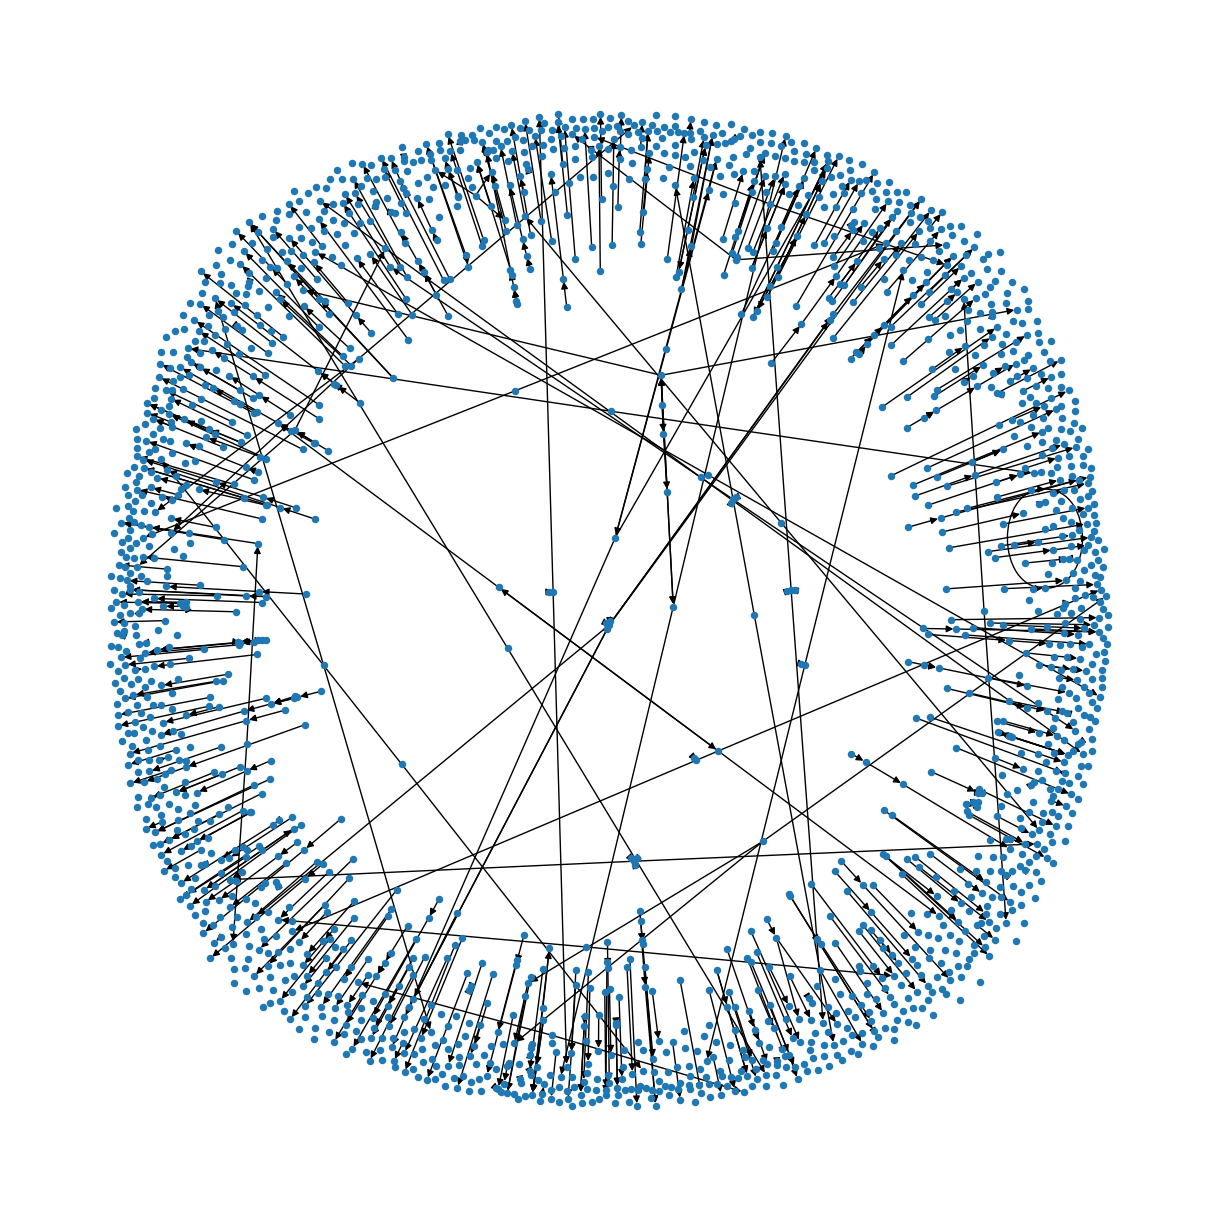

In [ ]:
# from networkx.drawing.nx_agraph import graphviz_layout
# 

# 4) (Optional) Visualize just that subgraph
subG = G.subgraph(sampled).copy()

plt.figure(figsize=(12,12))
pos = nx.spring_layout(subG)
# pos = nx.kamada_kawai_layout(subG)
# pos = graphviz_layout(subG, prog='sfdp')
# pos = nx.spectral_layout(subG)
# No labels on nodes
nx.draw(subG, pos, with_labels=False, node_size=15)

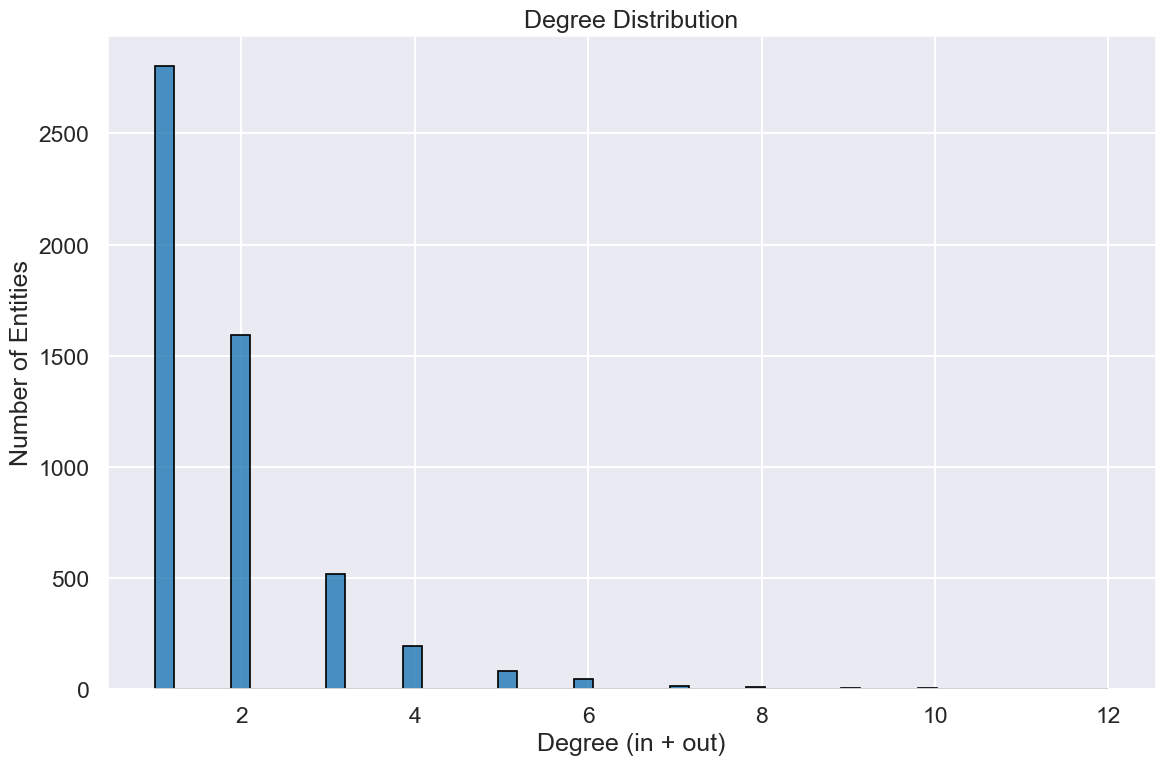

In [12]:


# 2) Build adjacency‐lookup and degree counts
nodes = set()
for h, _, t in triples:
    nodes.add(h); nodes.add(t)
nodes = list(nodes)
idx = {n:i for i, n in enumerate(nodes)}

# (a) Adjacency‐matrix
n = len(nodes)
adj = [[0]*n for _ in range(n)]
for h, _, t in triples:
    adj[idx[h]][idx[t]] = 1

# (b) Degree counts
deg = Counter()
for h, _, t in triples:
    deg[h] += 1
    deg[t] += 1
degrees = list(deg.values())

# 2) Set a Seaborn style
sns.set_style('darkgrid')       # darkgrid, whitegrid, ticks, etc.
sns.set_context('talk')         # talk, paper, notebook, poster

# 3) Plot with Seaborn’s histplot
plt.figure(figsize=(12, 8))
sns.histplot(degrees,
             bins=50,
             edgecolor='black',
             alpha=0.8,
             line_kws={'linewidth':1})
plt.title('Degree Distribution')
plt.xlabel('Degree (in + out)')
plt.ylabel('Number of Entities')
plt.tight_layout()
plt.show()

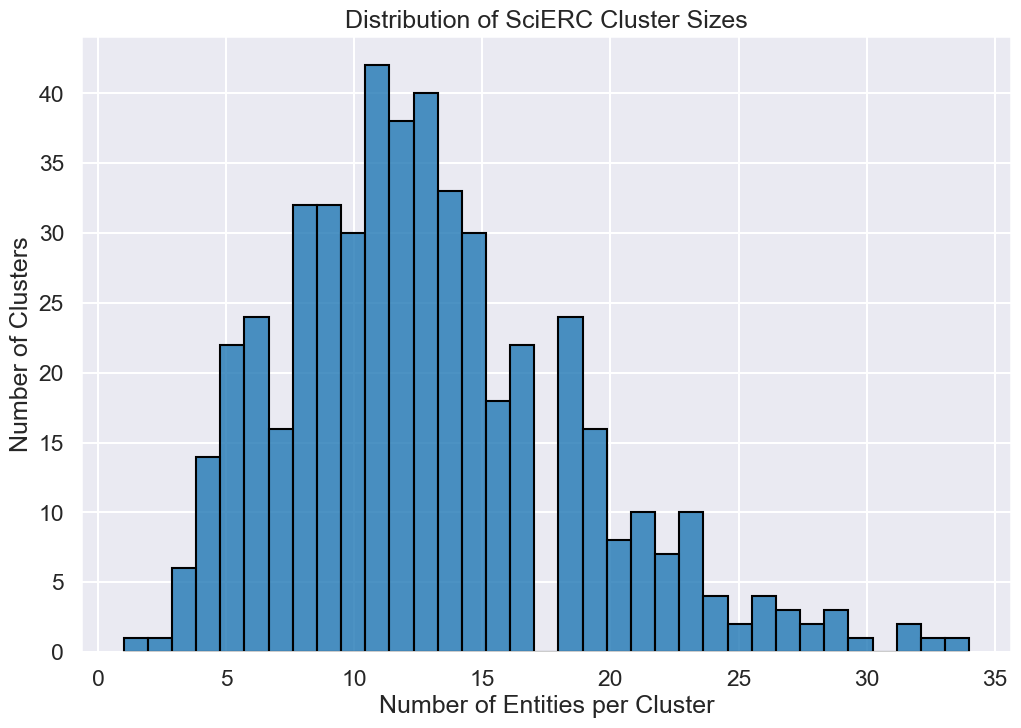

In [17]:
entity_names = list(entities.keys())

# Derive cluster from entity name prefix
clusters = [name.rsplit('_', 1)[0] for name in entity_names]

# Compute cluster sizes
from collections import Counter
cluster_sizes = Counter(clusters)

# Prepare data for plotting
sizes = list(cluster_sizes.values())

# Plot the distribution of cluster sizes as a histogram
sns.set_style('darkgrid')       # darkgrid, whitegrid, ticks, etc.
sns.set_context('talk')  
plt.figure(figsize=(12, 8))
sns.histplot(sizes,
             bins=35,
             edgecolor='black',
             alpha=0.8,
             line_kws={'linewidth':1})
plt.xlabel('Number of Entities per Cluster')
plt.ylabel('Number of Clusters')
plt.title('Distribution of SciERC Cluster Sizes')
plt.show()

# 2) Set a Seaborn style


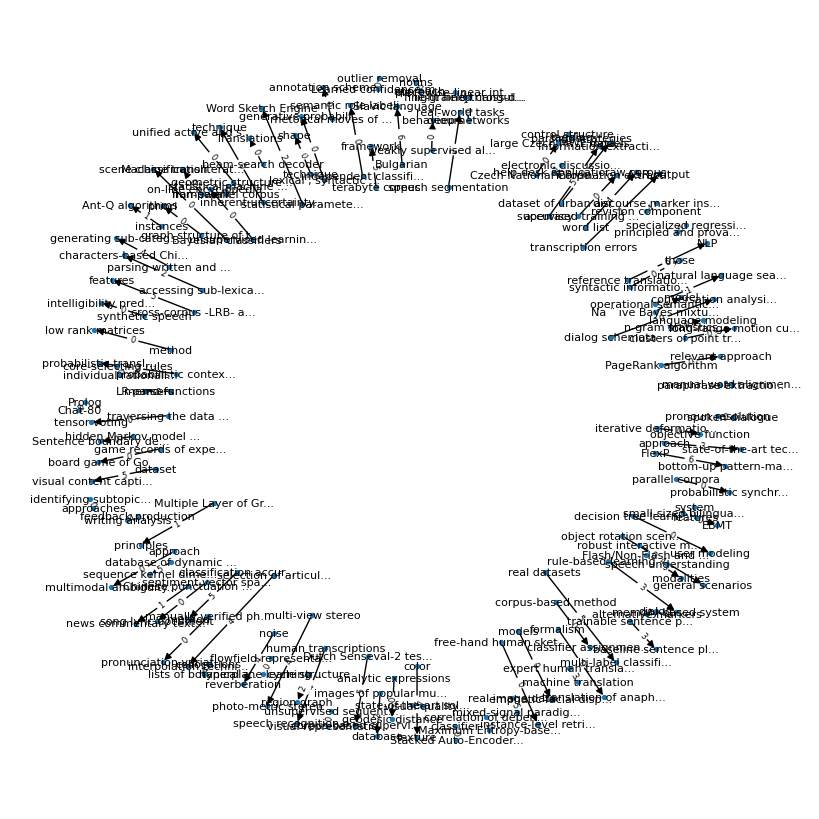

In [42]:
# Sample a subset of triples to visualize
sample_size = min(100, len(triples))
sampled_triples = random.sample(triples, sample_size)

# Build directed graph
G = nx.DiGraph()
for head, rel, tail in sampled_triples:
    G.add_node(head, label=entities[head]['canonical'])
    G.add_node(tail, label=entities[tail]['canonical'])
    G.add_edge(head, tail, label=rel)

# Prepare node labels (truncate for readability)
node_labels = {
    n: (entities[n]['canonical'][:20] + '...' if len(entities[n]['canonical']) > 20 else entities[n]['canonical'])
    for n in G.nodes()
}

# Draw
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=8, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
plt.axis('off')
plt.show()